In [1]:
""" (WGAN)
Wasserstein GAN as laid out in original paper.

https://arxiv.org/abs/1701.07875

WGAN utilizes the Wasserstein distance to produce a value function whichhas better theoretical properties 
than the vanilla GAN. In particular, the authors prove that there exist distributions for which Jenson-Shannon,
Kullback-Leibler, Reverse Kullback Leibler, and Total Variaton distance metrics where Wasserstein does. Furthermore,
the Wasserstein distance has guarantees of continuity and and differentiability in neural network settings where
the previously mentioned distributions may not. Lastly, they show that that every distribution that converges under 
KL, reverse-KL, TV, and JS divergences also converges under the Wasserstein divergence and that a small Wasserstein
distance corresponds to a small difference in distributions. The downside is that Wasserstein distance cannot be
tractably computed directly. But if we make sure the discriminator (aka Critic because it is not actually classifying) 
lies in the space of 1-Lipschitz functions, we can use that to approximate it instead. We crudely enforce this 
via a weight clamping parameter C.

Note that this implementation uses RMSprop optimizer instead of Adam as per the paper.

"""
import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import os
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm_notebook
from itertools import product
from load_data import get_data

def to_var(x):
    """ function to automatically cudarize.. """
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

# Load in data, separate into data loaders
train_iter, val_iter, test_iter = get_data()

In [6]:
class Generator(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim):
        """ Generator. Input is noise, output is a generated image. """
        super(Generator, self).__init__()
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.generate = nn.Linear(hidden_dim, image_size)
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        generation = F.sigmoid(self.generate(activated))
        return generation
        
class Discriminator(nn.Module):
    def __init__(self, image_size, hidden_dim, output_dim):
        """ Critic (not trained to classify). Input is an image (real or generated), output is the approximate Wasserstein Distance between z~P(G(z)) and real. """
        super(Discriminator, self).__init__()
        self.linear = nn.Linear(image_size, hidden_dim)
        self.discriminate = nn.Linear(hidden_dim, output_dim)     
        
    def forward(self, x):
        activated = F.relu(self.linear(x))
        discrimination = F.relu(self.discriminate(activated))
        return discrimination
    
class WGAN(nn.Module):
    def __init__(self, image_size, hidden_dim, z_dim, output_dim = 1):
        """ Super class to contain both Discriminator / Critic (D) and Generator (G) """
        super(WGAN, self).__init__()
        self.G = Generator(image_size, hidden_dim, z_dim)
        self.D = Discriminator(image_size, hidden_dim, output_dim)
        
        self.z_dim = z_dim
    
class Trainer:
    def __init__(self, train_iter, val_iter, test_iter):
        """ Object to hold data iterators, train a GAN variant """
        self.train_iter = train_iter
        self.val_iter = val_iter
        self.test_iter = test_iter
    
    def train(self, model, num_epochs, G_lr = 5e-5, D_lr = 5e-5, D_steps = 5, clip = 0.01):
        """ Train a Wasserstein GAN
            Logs progress using G loss, D loss, G(x), D(G(x)), visualizations of Generator output.

        Inputs:
            model: class, initialized GAN nn.module
            num_epochs: int, number of epochs to train for
            G_lr: float, learning rate for generator's Adam optimizer (default 5e-5)
            D_lr: float, learning rate for discriminator's Adam optimizer (default 5e-5)
            D_steps: int, training step ratio for how often to train D compared to G (default 5)
            clip: float, bound for parameters [-c, c] to crudely ensure K-Lipschitz (default 0.01, (range [-0.01, 0.01]))
        Outputs:
            model: trained WGAN instance 
        """
        # Note that in the original paper, the authors use RMSprop for more stable training (no explanation given)
        G_optimizer = torch.optim.RMSprop(params=[p for p in model.G.parameters() if p.requires_grad], lr=G_lr)
        D_optimizer = torch.optim.RMSprop(params=[p for p in model.D.parameters() if p.requires_grad], lr=D_lr)
        
        # Approximate steps/epoch given D_steps per epoch --> roughly train in the same way as if D_step (1) == G_step (1)
        epoch_steps = int(np.ceil(len(train_iter) / (D_steps))) 
        
        # Begin training
        for epoch in tqdm_notebook(range(1, num_epochs + 1)):
            model.train()
            G_losses, D_losses = [], []
            
            for _ in range(epoch_steps):
                
                D_step_loss = []
                
                # TRAINING D: Train D for D_steps (original WGAN paper e.g. 5)
                for _ in range(D_steps):
                    
                    # Retrieve batch
                    images = self.process_batch(self.train_iter)

                    # Zero out gradients for D
                    D_optimizer.zero_grad()
                    
                    # Train the discriminator to learn to approximate the Wasserstein distance between real and generated distributions
                    D_loss = self.train_D(model, images)
                    
                    # Update parameters
                    D_loss.backward()
                    D_optimizer.step()
                    
                    # Log results, backpropagate the discriminator network
                    D_step_loss.append(D_loss)
                    
                    # Clamp weights as per original paper (this is a crude way of ensuring K-Lipschitz)
                    self.clip_D_weights(model, clip)
            
                # We report D_loss in this way so that G_loss and D_loss have the same number of entries
                D_losses.append(np.mean(D_step_loss))
                                    
                # TRAINING G: Zero out gradients for G
                G_optimizer.zero_grad()

                # Train the generator to (roughly) minimize the approximated Wasserstein distance
                G_loss = self.train_G(model, images)

                # Update parameters
                G_loss.backward()
                G_optimizer.step()

                # Save relevant output for progress logging
                G_losses.append(G_loss)
                
            # Progress logging
            print ("Epoch[%d/%d], G Loss: %.4f, D Loss: %.4f"
                   %(epoch, num_epochs, np.mean(G_losses), np.mean(D_losses))) 
            
            # Visualize generator progress
            fig = self.generate_images(model, epoch)
            plt.show()
            
        return model
    
    def train_D(self, model, images):
        """ Run 1 step of training for discriminator

        Input:
            model: model instantiation
            images: batch of images (reshaped to [batch_size, 784])
        Output:
            D_loss: wasserstein loss for discriminator, -E[D(x)] + E[D(G(z))]
        """   
        
        # Sample from the generator
        noise = self.compute_noise(images.shape[0], model.z_dim)
        G_output = model.G(noise)
        
        # Score real, generated images
        DX_score = model.D(images) # D(x), "real"
        DG_score = model.D(G_output) # D(G(x')), "fake"
        
        # Compute WGAN loss for D
        D_loss = -(torch.mean(DX_score)) + torch.mean(DG_score)
        
        return D_loss
    
    def train_G(self, model, images):
        """ Run 1 step of training for generator
        
        Input:
            model: instantiated GAN
            images: batch of images reshaped to [batch_size, -1]    
        Output:
            G_loss: wasserstein loss for generator, -E[D(G(z))]
        """   
        # Get noise, classify it using G, then classify the output of G using D.
        noise = self.compute_noise(images.shape[0], model.z_dim) # z
        G_output = model.G(noise) # G(z)
        DG_score = model.D(G_output) # D(G(z))
        
        # Compute WGAN loss for G
        G_loss = -(torch.mean(DG_score))
        
        return G_loss
    
    def compute_noise(self, batch_size, z_dim):
        """ Compute random noise for the generator to learn to make images from """
        return to_var(torch.randn(batch_size, z_dim))
    
    def generate_images(self, model, epoch, num_outputs = 25, save = True):
        """ Visualize progress of generator learning """
        noise = self.compute_noise(num_outputs, model.z_dim)
        images = model.G(noise)
        images = images.view(images.shape[0], 28, 28)
        size_figure_grid = int(num_outputs**0.5)
        fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize=(5, 5))
        for i, j in product(range(size_figure_grid), range(size_figure_grid)):
            ax[i,j].get_xaxis().set_visible(False)
            ax[i,j].get_yaxis().set_visible(False)
            ax[i,j].cla()
            ax[i,j].imshow(images[i+j].data.numpy(), cmap='gray') 
        
        if save:
            if not os.path.exists('../viz/w-gan/'):
                os.makedirs('../viz/w-gan/')
            torchvision.utils.save_image(images.unsqueeze(1).data.cpu(), '../viz/w-gan/reconst_%d.png' %(epoch), nrow = 5)
        return fig
    
    def process_batch(self, iterator):
        """ Generate a process batch to be input into the discriminator D """
        images, _ = next(iter(iterator))
        images = to_var(images.view(images.shape[0], -1))
        return images
    
    def clip_D_weights(self, model, clip):
        for parameter in model.D.parameters():
            parameter.data.clamp_(-clip, clip)    

    def save_model(self, model, savepath):
        """ Save model state dictionary """
        torch.save(model.state_dict(), savepath + 'saved_gan.pth')
    
    def load_model(self, loadpath,  model = None):
        """ Load state dictionary into model. If model not specified, instantiate it """
        if not model:
            model = WGAN()
        state = torch.load(loadpath)
        model.load_state_dict(state)
        return model


Epoch[1/25], G Loss: -0.2087, D Loss: -0.4292


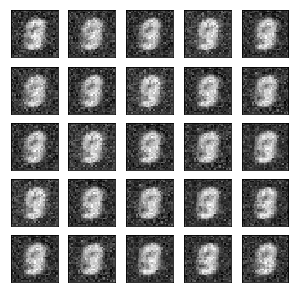

Epoch[2/25], G Loss: -0.1822, D Loss: -0.4234


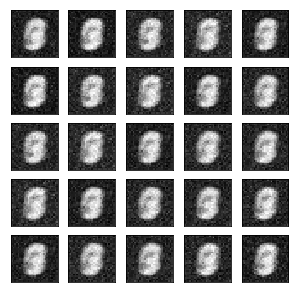

Epoch[3/25], G Loss: -0.1977, D Loss: -0.3038


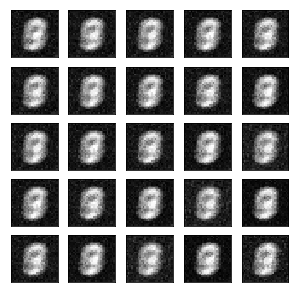

Epoch[4/25], G Loss: -0.2009, D Loss: -0.2322


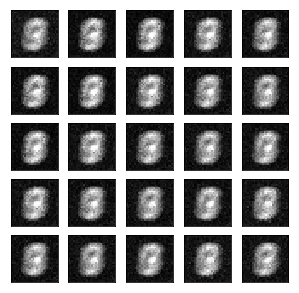

Epoch[5/25], G Loss: -0.2104, D Loss: -0.1803


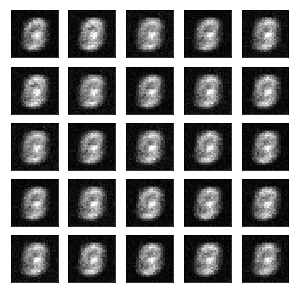

Epoch[6/25], G Loss: -0.2454, D Loss: -0.1282


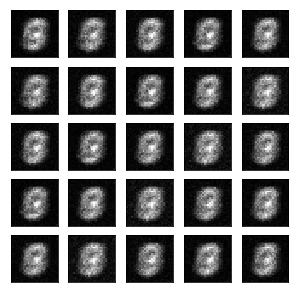

Epoch[7/25], G Loss: -0.3368, D Loss: -0.0834


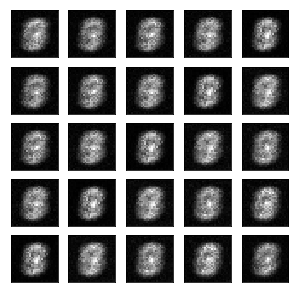

Epoch[8/25], G Loss: -0.4407, D Loss: -0.0595


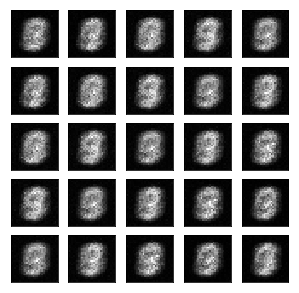

Epoch[9/25], G Loss: -0.4775, D Loss: -0.0451


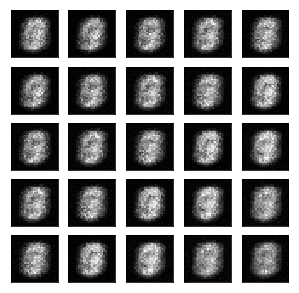

Epoch[10/25], G Loss: -0.4798, D Loss: -0.0362


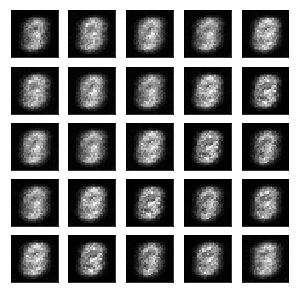

Epoch[11/25], G Loss: -0.4831, D Loss: -0.0303


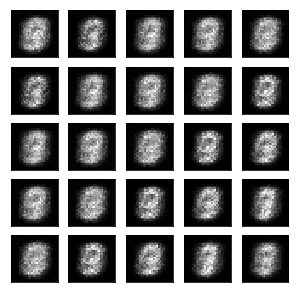

Epoch[12/25], G Loss: -0.4902, D Loss: -0.0261


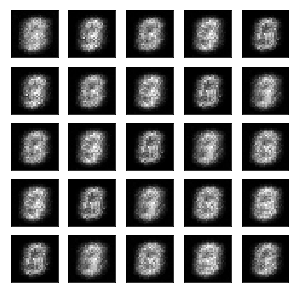

Epoch[13/25], G Loss: -0.4902, D Loss: -0.0226


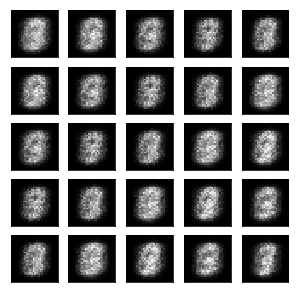

Epoch[14/25], G Loss: -0.4935, D Loss: -0.0198


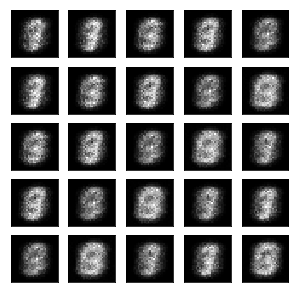

Epoch[15/25], G Loss: -0.4949, D Loss: -0.0176


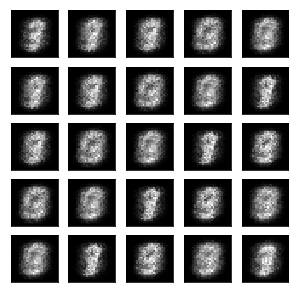

Epoch[16/25], G Loss: -0.4953, D Loss: -0.0153


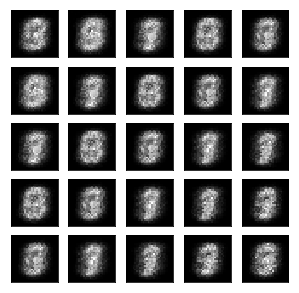

Epoch[17/25], G Loss: -0.4983, D Loss: -0.0134


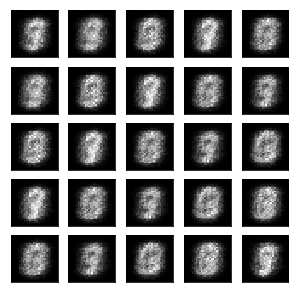

Epoch[18/25], G Loss: -0.4976, D Loss: -0.0118


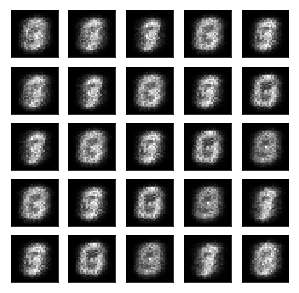

Epoch[19/25], G Loss: -0.4965, D Loss: -0.0113


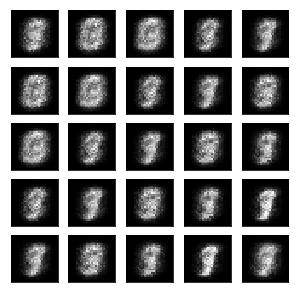

Epoch[20/25], G Loss: -0.4945, D Loss: -0.0133


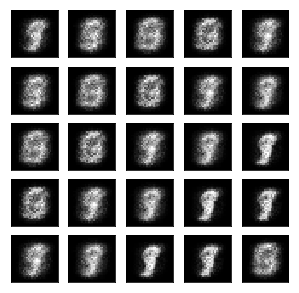

Epoch[21/25], G Loss: -0.4956, D Loss: -0.0168


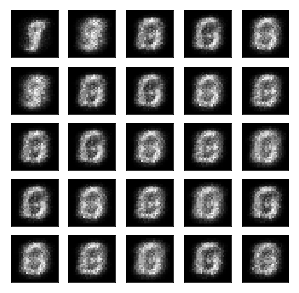

Epoch[22/25], G Loss: -0.4934, D Loss: -0.0182


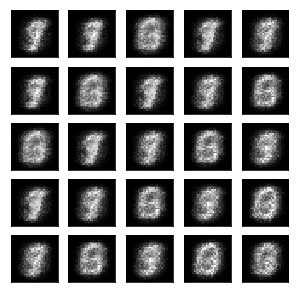

Epoch[23/25], G Loss: -0.4946, D Loss: -0.0182


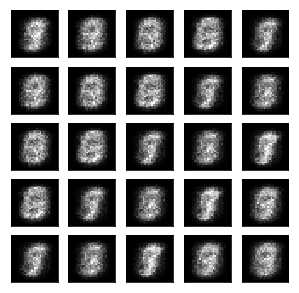

Epoch[24/25], G Loss: -0.4955, D Loss: -0.0179


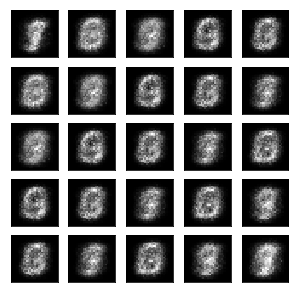

Epoch[25/25], G Loss: -0.4971, D Loss: -0.0171


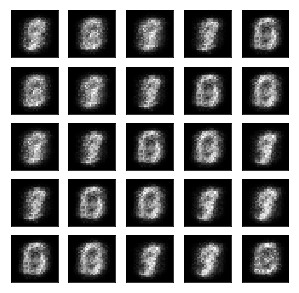

In [7]:
model = WGAN(image_size = 784, hidden_dim = 256, z_dim = 128)
if torch.cuda.is_available():
    model = model.cuda()
trainer = Trainer(train_iter, val_iter, test_iter)
model = trainer.train(model = model, num_epochs = 25, G_lr = 5e-5, D_lr = 5e-5, D_steps = 5, clip = 0.01)